In [15]:
import gym
import numpy as np
import inventory_model
import pandas as pd
from evaluate import *
from ppo_evaluate import ppo_evaluate
import matplotlib as plt


from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env

In [16]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
#wrapper for continuous environment
def ppo_eval(p, L, t_t, n_iter, learning_rate=0.0003):
    ContCONFIG = {'h': 1, 'p': p, 'L': L, 'lambda': 1}
    cont_env = make_vec_env('inventory_cont_config_model-v0', n_envs=4, env_kwargs=ContCONFIG)
    print("Running PPO w/: p=", p, ", L=",L)
    cont_model = PPO(MlpPolicy, cont_env, verbose=1, gamma = 1, learning_rate = learning_rate,use_sde = False)
    cont_model.learn(total_timesteps=t_t)#testing 2000

    cont_model.save("inv_cont_2")
    trained_model = PPO.load("inv_cont_2")
    env_eval = make_vec_env('inventory_cont_config_model-v0', n_envs=1, env_kwargs=ContCONFIG)
    numiter = n_iter#test
    res_mean, res_std = ppo_evaluate(trained_model, env_eval, numiter)
    print(-res_mean,'+/=',1.96*res_std/np.sqrt(5)) 

    return res_mean, res_std

In [ ]:
# listp = [0.25,1,4,9,39,99]
# listL = [1,4,10,20,30,50,70,100]
listp = [39]
listL = [1]
t_t = 200000
n_iter = 100000
learning_rate = 0.005
ppo_res = pd.DataFrame(columns = ['p','L','res_mean', 'res_std'])

for p in listp:
    for L in listL:
        res_mean, res_std = ppo_eval(p,L,t_t, n_iter, learning_rate)
        ppo_res = ppo_res.append({'p': p, 'L':L, 'res_mean':res_mean, 'res_std': res_std}, ignore_index=True)

In [ ]:
ppo_res

In [17]:
#wrapper for cont env, plot result for several steps
def ppo_eval_interval(p, L, t_t, n_iter, learning_rate=0.0003):
    ContCONFIG = {'h': 1, 'p': p, 'L': L, 'lambda': 1}
    cont_env = make_vec_env('inventory_cont_config_model-v0', n_envs=4, env_kwargs=ContCONFIG)
    print("Running PPO w/: p=", p, ", L=",L)
    cont_model = PPO(MlpPolicy, cont_env, verbose=1, gamma = 1, learning_rate = learning_rate,use_sde = False)
    env_eval = make_vec_env('inventory_cont_config_model-v0', n_envs=1, env_kwargs=ContCONFIG)
    timesteps = 0
    numiter = n_iter#test
    res_mean_arr = []
    res_std_arr = []

    while(timesteps <= t_t):

        cont_model.learn(total_timesteps=8000)#each iteration has 8192 timesteps with n_env=4
        timesteps = timesteps + 8192

        res_mean, res_std = ppo_evaluate(cont_model, env_eval, numiter)
        res_mean_arr.append(-res_mean)
        res_std_arr.append(res_std)
        print(res_mean_arr)
    
#     plt.pyplot.plot(res_mean_arr)

    return res_mean_arr, res_std_arr

In [18]:
# listp = [0.25,1,4,9,39,99]
# listL = [1,4,10,20,30,50,70,100]
listp = [9]
listL = [10]
t_t = 1000000
n_iter = 10000
learning_rate = 0.0003
ppo_res = pd.DataFrame(columns = ['p','L','res_mean', 'res_std'])

for p in listp:
    for L in listL:
        res_mean, res_std = ppo_eval_interval(p,L,t_t, n_iter, learning_rate)
        ppo_res = ppo_res.append({'p': p, 'L':L, 'res_mean':min(res_mean), 'res_std': res_std[np.argmin(res_mean)]}, ignore_index=True)

Running PPO w/: p= 9 , L= 10
Using cpu device
-----------------------------------------
| time/                   |             |
|    fps                  | 7740        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.006391395 |
|    clip_fraction        | 0.0609      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.18       |
|    explained_variance   | -2.38e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 57.8        |
|    n_updates            | 250         |
|    policy_gradient_loss | -0.0018     |
|    std                  | 0.775       |
|    value_loss           | 826         |
-----------------------------------------
mean:  -7.78670652883267
standard deviation: 0.25548911082700715
[7.78670652883267]
------------------------------------------
| time/                   |  

mean:  -6.074553641732036
standard deviation: 0.24303722658826474
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036]
-----------------------------------------
| time/                   |             |
|    fps                  | 6711        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.005222555 |
|    clip_fraction        | 0.0574      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.46       |
|    explained_variance   | -1.43e-06   |
|    learning_rate        | 0.0005      |
|    loss                 | 4.31e+03    |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.00537    |
|    std                  | 1.05        |
|    value_loss           | 1.18e+04    |
--------

mean:  -4.089548232877534
standard deviation: 0.27483561695962205
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534]
-----------------------------------------
| time/                   |             |
|    fps                  | 5753        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.005250342 |
|    clip_fraction        | 0.0524      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.39       |
|    explained_variance   | -2.38e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 1.18e+03    |
|    n_updates          

mean:  -3.6926925951097163
standard deviation: 0.09592514539684313
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163]
------------------------------------------
| time/                   |              |
|    fps                  | 7577         |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0033901883 |
|    clip_fraction        | 0.0485       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.25        |
|

mean:  -3.59539777574176
standard deviation: 0.13815167726643302
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163, 3.7246199413609835, 3.6748721512185414, 3.7467303205861184, 3.9207361556516966, 3.820063176624477, 3.59539777574176]
-----------------------------------------
| time/                   |             |
|    fps                  | 5758        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.006532709 |
|    clip_fraction     

mean:  -3.703092432087287
standard deviation: 0.24644328116208114
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163, 3.7246199413609835, 3.6748721512185414, 3.7467303205861184, 3.9207361556516966, 3.820063176624477, 3.59539777574176, 3.856199491259642, 3.675901929979213, 3.7049112873149803, 3.6190213599405716, 3.7660766371080996, 3.703092432087287]
------------------------------------------
| time/                   |              |
|    fps                  | 5823         |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      

------------------------------------------
| time/                   |              |
|    fps                  | 7041         |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0067757037 |
|    clip_fraction        | 0.0644       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.948       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0005       |
|    loss                 | 693          |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.00275     |
|    std                  | 0.622        |
|    value_loss           | 3.32e+03     |
------------------------------------------
mean:  -3.7220759455200287
standard deviation: 0.212919369963271
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622

-----------------------------------------
| time/                   |             |
|    fps                  | 7393        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.006668796 |
|    clip_fraction        | 0.0467      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.879      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 686         |
|    n_updates            | 460         |
|    policy_gradient_loss | -0.000337   |
|    std                  | 0.582       |
|    value_loss           | 3.11e+03    |
-----------------------------------------
mean:  -3.545034484469052
standard deviation: 0.1351503052541131
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607

------------------------------------------
| time/                   |              |
|    fps                  | 6393         |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0057638874 |
|    clip_fraction        | 0.0488       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.817       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0005       |
|    loss                 | 605          |
|    n_updates            | 510          |
|    policy_gradient_loss | -0.00241     |
|    std                  | 0.546        |
|    value_loss           | 2.86e+03     |
------------------------------------------
mean:  -3.617511649868498
standard deviation: 0.14675573676272255
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.62

mean:  -3.5108598799495025
standard deviation: 0.15953708789917692
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163, 3.7246199413609835, 3.6748721512185414, 3.7467303205861184, 3.9207361556516966, 3.820063176624477, 3.59539777574176, 3.856199491259642, 3.675901929979213, 3.7049112873149803, 3.6190213599405716, 3.7660766371080996, 3.703092432087287, 3.6597495386436583, 3.661326907817088, 3.517083432628773, 3.6363672469813375, 3.858752631579409, 3.7220759455200287, 3.5661236961122604, 3.555679643502832, 3.5148516446183438, 3.4139107575535776, 3.545034484469052, 3.5911178722046317, 3.563

-----------------------------------------
| time/                   |             |
|    fps                  | 7892        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.006816359 |
|    clip_fraction        | 0.0637      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.697      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 620         |
|    n_updates            | 600         |
|    policy_gradient_loss | -0.00217    |
|    std                  | 0.487       |
|    value_loss           | 2.99e+03    |
-----------------------------------------
mean:  -3.620809413522482
standard deviation: 0.06602533973794929
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 7138        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.009879444 |
|    clip_fraction        | 0.0641      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.663      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 526         |
|    n_updates            | 640         |
|    policy_gradient_loss | -0.00171    |
|    std                  | 0.469       |
|    value_loss           | 2.94e+03    |
-----------------------------------------
mean:  -3.4456942054988504
standard deviation: 0.2095114754543343
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

------------------------------------------
| time/                   |              |
|    fps                  | 7854         |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0075276103 |
|    clip_fraction        | 0.0579       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.592       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0005       |
|    loss                 | 619          |
|    n_updates            | 680          |
|    policy_gradient_loss | -0.00171     |
|    std                  | 0.436        |
|    value_loss           | 2.69e+03     |
------------------------------------------
mean:  -3.2688206142503766
standard deviation: 0.1116199565188785
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.62

-----------------------------------------
| time/                   |             |
|    fps                  | 7725        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.008214764 |
|    clip_fraction        | 0.0687      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.523      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 584         |
|    n_updates            | 720         |
|    policy_gradient_loss | -0.000915   |
|    std                  | 0.407       |
|    value_loss           | 2.64e+03    |
-----------------------------------------
mean:  -3.311565282658441
standard deviation: 0.16353776526647362
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 6110        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.009186257 |
|    clip_fraction        | 0.064       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.467      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 673         |
|    n_updates            | 760         |
|    policy_gradient_loss | -0.00189    |
|    std                  | 0.382       |
|    value_loss           | 2.77e+03    |
-----------------------------------------
mean:  -3.3414851909690184
standard deviation: 0.15417753436444248
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 6266        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010140566 |
|    clip_fraction        | 0.0701      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.412      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 432         |
|    n_updates            | 800         |
|    policy_gradient_loss | -0.00132    |
|    std                  | 0.367       |
|    value_loss           | 2.71e+03    |
-----------------------------------------
mean:  -3.2345427283992527
standard deviation: 0.08539726883452001
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 5843        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010259456 |
|    clip_fraction        | 0.0684      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.391      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 521         |
|    n_updates            | 840         |
|    policy_gradient_loss | -0.0021     |
|    std                  | 0.358       |
|    value_loss           | 2.76e+03    |
-----------------------------------------
mean:  -3.1589163328504193
standard deviation: 0.18758226524266866
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

mean:  -3.3047030204629992
standard deviation: 0.16317583905758595
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163, 3.7246199413609835, 3.6748721512185414, 3.7467303205861184, 3.9207361556516966, 3.820063176624477, 3.59539777574176, 3.856199491259642, 3.675901929979213, 3.7049112873149803, 3.6190213599405716, 3.7660766371080996, 3.703092432087287, 3.6597495386436583, 3.661326907817088, 3.517083432628773, 3.6363672469813375, 3.858752631579409, 3.7220759455200287, 3.5661236961122604, 3.555679643502832, 3.5148516446183438, 3.4139107575535776, 3.545034484469052, 3.5911178722046317, 3.563

-----------------------------------------
| time/                   |             |
|    fps                  | 7446        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.007429504 |
|    clip_fraction        | 0.0717      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.341      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 523         |
|    n_updates            | 910         |
|    policy_gradient_loss | -0.0013     |
|    std                  | 0.339       |
|    value_loss           | 2.48e+03    |
-----------------------------------------
mean:  -3.4203014813246204
standard deviation: 0.21388655800688397
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

mean:  -3.4012711931735273
standard deviation: 0.17505129931143298
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163, 3.7246199413609835, 3.6748721512185414, 3.7467303205861184, 3.9207361556516966, 3.820063176624477, 3.59539777574176, 3.856199491259642, 3.675901929979213, 3.7049112873149803, 3.6190213599405716, 3.7660766371080996, 3.703092432087287, 3.6597495386436583, 3.661326907817088, 3.517083432628773, 3.6363672469813375, 3.858752631579409, 3.7220759455200287, 3.5661236961122604, 3.555679643502832, 3.5148516446183438, 3.4139107575535776, 3.545034484469052, 3.5911178722046317, 3.563

mean:  -3.224265700514242
standard deviation: 0.16698785192133353
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163, 3.7246199413609835, 3.6748721512185414, 3.7467303205861184, 3.9207361556516966, 3.820063176624477, 3.59539777574176, 3.856199491259642, 3.675901929979213, 3.7049112873149803, 3.6190213599405716, 3.7660766371080996, 3.703092432087287, 3.6597495386436583, 3.661326907817088, 3.517083432628773, 3.6363672469813375, 3.858752631579409, 3.7220759455200287, 3.5661236961122604, 3.555679643502832, 3.5148516446183438, 3.4139107575535776, 3.545034484469052, 3.5911178722046317, 3.5633

mean:  -3.294992672782019
standard deviation: 0.1652277557315526
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163, 3.7246199413609835, 3.6748721512185414, 3.7467303205861184, 3.9207361556516966, 3.820063176624477, 3.59539777574176, 3.856199491259642, 3.675901929979213, 3.7049112873149803, 3.6190213599405716, 3.7660766371080996, 3.703092432087287, 3.6597495386436583, 3.661326907817088, 3.517083432628773, 3.6363672469813375, 3.858752631579409, 3.7220759455200287, 3.5661236961122604, 3.555679643502832, 3.5148516446183438, 3.4139107575535776, 3.545034484469052, 3.5911178722046317, 3.56331

mean:  -3.3500852893466826
standard deviation: 0.10452269475921469
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163, 3.7246199413609835, 3.6748721512185414, 3.7467303205861184, 3.9207361556516966, 3.820063176624477, 3.59539777574176, 3.856199491259642, 3.675901929979213, 3.7049112873149803, 3.6190213599405716, 3.7660766371080996, 3.703092432087287, 3.6597495386436583, 3.661326907817088, 3.517083432628773, 3.6363672469813375, 3.858752631579409, 3.7220759455200287, 3.5661236961122604, 3.555679643502832, 3.5148516446183438, 3.4139107575535776, 3.545034484469052, 3.5911178722046317, 3.563

mean:  -3.3594529299617277
standard deviation: 0.22990173757107746
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163, 3.7246199413609835, 3.6748721512185414, 3.7467303205861184, 3.9207361556516966, 3.820063176624477, 3.59539777574176, 3.856199491259642, 3.675901929979213, 3.7049112873149803, 3.6190213599405716, 3.7660766371080996, 3.703092432087287, 3.6597495386436583, 3.661326907817088, 3.517083432628773, 3.6363672469813375, 3.858752631579409, 3.7220759455200287, 3.5661236961122604, 3.555679643502832, 3.5148516446183438, 3.4139107575535776, 3.545034484469052, 3.5911178722046317, 3.563

mean:  -3.437637014272
standard deviation: 0.10580788498591016
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163, 3.7246199413609835, 3.6748721512185414, 3.7467303205861184, 3.9207361556516966, 3.820063176624477, 3.59539777574176, 3.856199491259642, 3.675901929979213, 3.7049112873149803, 3.6190213599405716, 3.7660766371080996, 3.703092432087287, 3.6597495386436583, 3.661326907817088, 3.517083432628773, 3.6363672469813375, 3.858752631579409, 3.7220759455200287, 3.5661236961122604, 3.555679643502832, 3.5148516446183438, 3.4139107575535776, 3.545034484469052, 3.5911178722046317, 3.5633146

-----------------------------------------
| time/                   |             |
|    fps                  | 7057        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010255009 |
|    clip_fraction        | 0.0788      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.194      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 492         |
|    n_updates            | 1120        |
|    policy_gradient_loss | -0.000873   |
|    std                  | 0.294       |
|    value_loss           | 2.67e+03    |
-----------------------------------------
mean:  -3.2679789056872486
standard deviation: 0.1403747248406217
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 7359        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010659455 |
|    clip_fraction        | 0.0804      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.159      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 472         |
|    n_updates            | 1150        |
|    policy_gradient_loss | 3.73e-05    |
|    std                  | 0.283       |
|    value_loss           | 2.36e+03    |
-----------------------------------------
mean:  -3.2443684215864863
standard deviation: 0.03983959655803641
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7581        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.006268733 |
|    clip_fraction        | 0.0718      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.109      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 319         |
|    n_updates            | 1180        |
|    policy_gradient_loss | -0.000567   |
|    std                  | 0.27        |
|    value_loss           | 2.29e+03    |
-----------------------------------------
mean:  -3.364219800946396
standard deviation: 0.135623243076455
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6074

------------------------------------------
| time/                   |              |
|    fps                  | 7323         |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0076212278 |
|    clip_fraction        | 0.0736       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.101       |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0005       |
|    loss                 | 417          |
|    n_updates            | 1210         |
|    policy_gradient_loss | -0.00151     |
|    std                  | 0.269        |
|    value_loss           | 2.35e+03     |
------------------------------------------
mean:  -3.350105724855512
standard deviation: 0.17168448057957741
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.62

-----------------------------------------
| time/                   |             |
|    fps                  | 7479        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.008314813 |
|    clip_fraction        | 0.0682      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0945     |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 458         |
|    n_updates            | 1240        |
|    policy_gradient_loss | 0.000107    |
|    std                  | 0.265       |
|    value_loss           | 2.62e+03    |
-----------------------------------------
mean:  -3.3968266231063753
standard deviation: 0.13050403502043978
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 4240        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012601139 |
|    clip_fraction        | 0.0764      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0842     |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 605         |
|    n_updates            | 1270        |
|    policy_gradient_loss | -0.000444   |
|    std                  | 0.263       |
|    value_loss           | 2.79e+03    |
-----------------------------------------
mean:  -3.397514926313795
standard deviation: 0.13661602034025003
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 7184        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.014158754 |
|    clip_fraction        | 0.0916      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.06       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0005      |
|    loss                 | 492         |
|    n_updates            | 1300        |
|    policy_gradient_loss | -0.002      |
|    std                  | 0.256       |
|    value_loss           | 2.71e+03    |
-----------------------------------------
mean:  -3.437812646553945
standard deviation: 0.04976956549225655
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 7906        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.009947131 |
|    clip_fraction        | 0.0912      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0224     |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0005      |
|    loss                 | 444         |
|    n_updates            | 1330        |
|    policy_gradient_loss | -0.000353   |
|    std                  | 0.248       |
|    value_loss           | 2.51e+03    |
-----------------------------------------
mean:  -3.2607673738352956
standard deviation: 0.12440340676635804
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7846        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010703851 |
|    clip_fraction        | 0.088       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0177     |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 384         |
|    n_updates            | 1360        |
|    policy_gradient_loss | -0.000609   |
|    std                  | 0.247       |
|    value_loss           | 2.53e+03    |
-----------------------------------------
mean:  -3.317848750650138
standard deviation: 0.14447891675613933
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 7746        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.008094588 |
|    clip_fraction        | 0.0755      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.00854    |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 429         |
|    n_updates            | 1390        |
|    policy_gradient_loss | -0.000358   |
|    std                  | 0.243       |
|    value_loss           | 2.47e+03    |
-----------------------------------------
mean:  -3.2034968005903997
standard deviation: 0.07580118511684389
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7898        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.016778156 |
|    clip_fraction        | 0.0799      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0258      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 307         |
|    n_updates            | 1420        |
|    policy_gradient_loss | -0.000947   |
|    std                  | 0.237       |
|    value_loss           | 2.33e+03    |
-----------------------------------------
mean:  -3.1603954812430777
standard deviation: 0.07287184636423294
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7768        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.013354113 |
|    clip_fraction        | 0.0802      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0147      |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 459         |
|    n_updates            | 1450        |
|    policy_gradient_loss | -0.000962   |
|    std                  | 0.24        |
|    value_loss           | 2.65e+03    |
-----------------------------------------
mean:  -3.360596442417055
standard deviation: 0.10528993645947422
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

mean:  -3.400179213792458
standard deviation: 0.1519368716732963
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163, 3.7246199413609835, 3.6748721512185414, 3.7467303205861184, 3.9207361556516966, 3.820063176624477, 3.59539777574176, 3.856199491259642, 3.675901929979213, 3.7049112873149803, 3.6190213599405716, 3.7660766371080996, 3.703092432087287, 3.6597495386436583, 3.661326907817088, 3.517083432628773, 3.6363672469813375, 3.858752631579409, 3.7220759455200287, 3.5661236961122604, 3.555679643502832, 3.5148516446183438, 3.4139107575535776, 3.545034484469052, 3.5911178722046317, 3.56331

-----------------------------------------
| time/                   |             |
|    fps                  | 7848        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.009823009 |
|    clip_fraction        | 0.0798      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0344      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 602         |
|    n_updates            | 1500        |
|    policy_gradient_loss | -0.00104    |
|    std                  | 0.235       |
|    value_loss           | 2.66e+03    |
-----------------------------------------
mean:  -3.389259856228717
standard deviation: 0.12692954839767254
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

mean:  -3.453795855344599
standard deviation: 0.28918371998503967
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163, 3.7246199413609835, 3.6748721512185414, 3.7467303205861184, 3.9207361556516966, 3.820063176624477, 3.59539777574176, 3.856199491259642, 3.675901929979213, 3.7049112873149803, 3.6190213599405716, 3.7660766371080996, 3.703092432087287, 3.6597495386436583, 3.661326907817088, 3.517083432628773, 3.6363672469813375, 3.858752631579409, 3.7220759455200287, 3.5661236961122604, 3.555679643502832, 3.5148516446183438, 3.4139107575535776, 3.545034484469052, 3.5911178722046317, 3.5633

----------------------------------------
| time/                   |            |
|    fps                  | 7816       |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01048376 |
|    clip_fraction        | 0.0824     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.0645     |
|    explained_variance   | 0          |
|    learning_rate        | 0.0005     |
|    loss                 | 405        |
|    n_updates            | 1550       |
|    policy_gradient_loss | -0.00223   |
|    std                  | 0.226      |
|    value_loss           | 2.51e+03   |
----------------------------------------
mean:  -3.283493379409891
standard deviation: 0.20776098070113877
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.07

mean:  -3.4510044841650873
standard deviation: 0.12697592605698427
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163, 3.7246199413609835, 3.6748721512185414, 3.7467303205861184, 3.9207361556516966, 3.820063176624477, 3.59539777574176, 3.856199491259642, 3.675901929979213, 3.7049112873149803, 3.6190213599405716, 3.7660766371080996, 3.703092432087287, 3.6597495386436583, 3.661326907817088, 3.517083432628773, 3.6363672469813375, 3.858752631579409, 3.7220759455200287, 3.5661236961122604, 3.555679643502832, 3.5148516446183438, 3.4139107575535776, 3.545034484469052, 3.5911178722046317, 3.563

-----------------------------------------
| time/                   |             |
|    fps                  | 7526        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.008988956 |
|    clip_fraction        | 0.0705      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.0998      |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 462         |
|    n_updates            | 1600        |
|    policy_gradient_loss | 0.000176    |
|    std                  | 0.219       |
|    value_loss           | 2.72e+03    |
-----------------------------------------
mean:  -3.386377146539651
standard deviation: 0.17382398565823523
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

mean:  -3.2664439636707305
standard deviation: 0.09206399025492805
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074553641732036, 5.885117014442734, 5.2876745851050595, 5.000642900110735, 4.883838023288082, 4.462434165151789, 4.235514196913923, 4.25717244312372, 4.089548232877534, 4.061121747920487, 3.860758050875738, 3.9002685502760115, 3.904452170971316, 3.8515007471993563, 3.8737363351475453, 3.6926925951097163, 3.7246199413609835, 3.6748721512185414, 3.7467303205861184, 3.9207361556516966, 3.820063176624477, 3.59539777574176, 3.856199491259642, 3.675901929979213, 3.7049112873149803, 3.6190213599405716, 3.7660766371080996, 3.703092432087287, 3.6597495386436583, 3.661326907817088, 3.517083432628773, 3.6363672469813375, 3.858752631579409, 3.7220759455200287, 3.5661236961122604, 3.555679643502832, 3.5148516446183438, 3.4139107575535776, 3.545034484469052, 3.5911178722046317, 3.563

-----------------------------------------
| time/                   |             |
|    fps                  | 7403        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.009273225 |
|    clip_fraction        | 0.0889      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.139       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 487         |
|    n_updates            | 1650        |
|    policy_gradient_loss | -0.000536   |
|    std                  | 0.211       |
|    value_loss           | 2.55e+03    |
-----------------------------------------
mean:  -3.428167744979914
standard deviation: 0.22026748772517593
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 7239        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010872185 |
|    clip_fraction        | 0.0833      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.134       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 389         |
|    n_updates            | 1670        |
|    policy_gradient_loss | -0.00108    |
|    std                  | 0.212       |
|    value_loss           | 2.21e+03    |
-----------------------------------------
mean:  -3.318765489960834
standard deviation: 0.17670539540907254
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 7272        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.007991591 |
|    clip_fraction        | 0.0785      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.146       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 411         |
|    n_updates            | 1690        |
|    policy_gradient_loss | -0.00117    |
|    std                  | 0.209       |
|    value_loss           | 2.49e+03    |
-----------------------------------------
mean:  -3.254143071706779
standard deviation: 0.13398612384007982
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 4681        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.009928813 |
|    clip_fraction        | 0.0847      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.166       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0005      |
|    loss                 | 320         |
|    n_updates            | 1710        |
|    policy_gradient_loss | -8.4e-05    |
|    std                  | 0.204       |
|    value_loss           | 2.31e+03    |
-----------------------------------------
mean:  -3.4362724051336757
standard deviation: 0.0771689627600991
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

----------------------------------------
| time/                   |            |
|    fps                  | 7904       |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01290329 |
|    clip_fraction        | 0.0868     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.18       |
|    explained_variance   | 0          |
|    learning_rate        | 0.0005     |
|    loss                 | 304        |
|    n_updates            | 1730       |
|    policy_gradient_loss | -0.000968  |
|    std                  | 0.202      |
|    value_loss           | 2.32e+03   |
----------------------------------------
mean:  -3.3314402500545603
standard deviation: 0.1742450058494313
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.07

-----------------------------------------
| time/                   |             |
|    fps                  | 7820        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.011413613 |
|    clip_fraction        | 0.0834      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.183       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 480         |
|    n_updates            | 1750        |
|    policy_gradient_loss | -0.00159    |
|    std                  | 0.202       |
|    value_loss           | 2.53e+03    |
-----------------------------------------
mean:  -3.227169958068989
standard deviation: 0.1884757529002284
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607

-----------------------------------------
| time/                   |             |
|    fps                  | 7997        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010611272 |
|    clip_fraction        | 0.0803      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.174       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 428         |
|    n_updates            | 1770        |
|    policy_gradient_loss | -0.000305   |
|    std                  | 0.204       |
|    value_loss           | 2.48e+03    |
-----------------------------------------
mean:  -3.242435421728343
standard deviation: 0.12107797240650324
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 8028        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012214223 |
|    clip_fraction        | 0.0928      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.18        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 441         |
|    n_updates            | 1790        |
|    policy_gradient_loss | -0.000996   |
|    std                  | 0.201       |
|    value_loss           | 2.44e+03    |
-----------------------------------------
mean:  -3.312045205991855
standard deviation: 0.04387249415660091
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

----------------------------------------
| time/                   |            |
|    fps                  | 7739       |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01129812 |
|    clip_fraction        | 0.0862     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.203      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0005     |
|    loss                 | 533        |
|    n_updates            | 1810       |
|    policy_gradient_loss | -0.000754  |
|    std                  | 0.198      |
|    value_loss           | 2.45e+03   |
----------------------------------------
mean:  -3.2685634445659817
standard deviation: 0.29668220886177243
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.0

-----------------------------------------
| time/                   |             |
|    fps                  | 7120        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012799141 |
|    clip_fraction        | 0.0914      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.234       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 393         |
|    n_updates            | 1830        |
|    policy_gradient_loss | -0.000832   |
|    std                  | 0.191       |
|    value_loss           | 2.35e+03    |
-----------------------------------------
mean:  -3.4358895025354577
standard deviation: 0.1769794770162714
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 7539        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.016197484 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.229       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 578         |
|    n_updates            | 1850        |
|    policy_gradient_loss | -0.00229    |
|    std                  | 0.193       |
|    value_loss           | 2.48e+03    |
-----------------------------------------
mean:  -3.35613188941218
standard deviation: 0.15998077713013517
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607

----------------------------------------
| time/                   |            |
|    fps                  | 7967       |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01363064 |
|    clip_fraction        | 0.0922     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.249      |
|    explained_variance   | -1.19e-07  |
|    learning_rate        | 0.0005     |
|    loss                 | 438        |
|    n_updates            | 1870       |
|    policy_gradient_loss | -0.00272   |
|    std                  | 0.19       |
|    value_loss           | 2.77e+03   |
----------------------------------------
mean:  -3.4822405772102067
standard deviation: 0.09055932007154947
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.0

-----------------------------------------
| time/                   |             |
|    fps                  | 8001        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.009919483 |
|    clip_fraction        | 0.084       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.253       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 701         |
|    n_updates            | 1890        |
|    policy_gradient_loss | -0.000262   |
|    std                  | 0.188       |
|    value_loss           | 2.85e+03    |
-----------------------------------------
mean:  -3.3994723764382306
standard deviation: 0.15243738429342946
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7892        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012417579 |
|    clip_fraction        | 0.0958      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.242       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 474         |
|    n_updates            | 1910        |
|    policy_gradient_loss | -0.00124    |
|    std                  | 0.19        |
|    value_loss           | 2.58e+03    |
-----------------------------------------
mean:  -3.2924095291774718
standard deviation: 0.17608190708964472
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7939        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012136379 |
|    clip_fraction        | 0.0906      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.244       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 454         |
|    n_updates            | 1930        |
|    policy_gradient_loss | -0.00067    |
|    std                  | 0.19        |
|    value_loss           | 2.6e+03     |
-----------------------------------------
mean:  -3.2935277488637715
standard deviation: 0.1838627406122929
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 6017        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012257125 |
|    clip_fraction        | 0.0886      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.241       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 336         |
|    n_updates            | 1950        |
|    policy_gradient_loss | 4.81e-05    |
|    std                  | 0.191       |
|    value_loss           | 2.49e+03    |
-----------------------------------------
mean:  -3.385809796772618
standard deviation: 0.15526912858449396
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

------------------------------------------
| time/                   |              |
|    fps                  | 6051         |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0075241737 |
|    clip_fraction        | 0.0878       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.272        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0005       |
|    loss                 | 371          |
|    n_updates            | 1970         |
|    policy_gradient_loss | -0.000595    |
|    std                  | 0.183        |
|    value_loss           | 2.58e+03     |
------------------------------------------
mean:  -3.444704975808412
standard deviation: 0.12263149253278711
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.62

-----------------------------------------
| time/                   |             |
|    fps                  | 8040        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.013871605 |
|    clip_fraction        | 0.0958      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.3         |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 548         |
|    n_updates            | 1990        |
|    policy_gradient_loss | -0.00103    |
|    std                  | 0.178       |
|    value_loss           | 2.76e+03    |
-----------------------------------------
mean:  -3.5650669901773333
standard deviation: 0.0526001924505096
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 7691        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.015668849 |
|    clip_fraction        | 0.0993      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.318       |
|    explained_variance   | -2.38e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 395         |
|    n_updates            | 2010        |
|    policy_gradient_loss | -0.00104    |
|    std                  | 0.176       |
|    value_loss           | 2.42e+03    |
-----------------------------------------
mean:  -3.4281660167914816
standard deviation: 0.1415712729588082
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

----------------------------------------
| time/                   |            |
|    fps                  | 7871       |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01078302 |
|    clip_fraction        | 0.0939     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.34       |
|    explained_variance   | -2.38e-07  |
|    learning_rate        | 0.0005     |
|    loss                 | 439        |
|    n_updates            | 2030       |
|    policy_gradient_loss | -0.000319  |
|    std                  | 0.172      |
|    value_loss           | 2.43e+03   |
----------------------------------------
mean:  -3.2665292226291265
standard deviation: 0.1925265613284016
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.07

-----------------------------------------
| time/                   |             |
|    fps                  | 7816        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010829326 |
|    clip_fraction        | 0.099       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.37        |
|    explained_variance   | -2.38e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 374         |
|    n_updates            | 2050        |
|    policy_gradient_loss | -0.00172    |
|    std                  | 0.166       |
|    value_loss           | 2.24e+03    |
-----------------------------------------
mean:  -3.2870340076170863
standard deviation: 0.03454261673961092
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7116        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012940761 |
|    clip_fraction        | 0.0855      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.391       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 391         |
|    n_updates            | 2070        |
|    policy_gradient_loss | 7.69e-05    |
|    std                  | 0.163       |
|    value_loss           | 2.34e+03    |
-----------------------------------------
mean:  -3.2765140876471066
standard deviation: 0.10356502813158999
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7945        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.009546395 |
|    clip_fraction        | 0.0827      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.396       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 439         |
|    n_updates            | 2090        |
|    policy_gradient_loss | -0.000122   |
|    std                  | 0.164       |
|    value_loss           | 2.43e+03    |
-----------------------------------------
mean:  -3.228591228405759
standard deviation: 0.12370136181727295
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 6300        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010251868 |
|    clip_fraction        | 0.0988      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.395       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 460         |
|    n_updates            | 2110        |
|    policy_gradient_loss | -0.000723   |
|    std                  | 0.163       |
|    value_loss           | 2.41e+03    |
-----------------------------------------
mean:  -3.28559295487348
standard deviation: 0.19921218590364462
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607

------------------------------------------
| time/                   |              |
|    fps                  | 7866         |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0138789825 |
|    clip_fraction        | 0.0921       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.404        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0005       |
|    loss                 | 447          |
|    n_updates            | 2130         |
|    policy_gradient_loss | -0.000656    |
|    std                  | 0.162        |
|    value_loss           | 2.5e+03      |
------------------------------------------
mean:  -3.30978731228672
standard deviation: 0.15778793548521655
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622

-----------------------------------------
| time/                   |             |
|    fps                  | 6546        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.013008273 |
|    clip_fraction        | 0.0951      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.412       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 630         |
|    n_updates            | 2150        |
|    policy_gradient_loss | -0.000371   |
|    std                  | 0.16        |
|    value_loss           | 2.57e+03    |
-----------------------------------------
mean:  -3.3686092786673454
standard deviation: 0.07952720617794833
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7145        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.018973913 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.418       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 490         |
|    n_updates            | 2170        |
|    policy_gradient_loss | -0.00135    |
|    std                  | 0.159       |
|    value_loss           | 2.63e+03    |
-----------------------------------------
mean:  -3.3228081016905606
standard deviation: 0.13702939292539773
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7135        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.017067593 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.46        |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0005      |
|    loss                 | 458         |
|    n_updates            | 2190        |
|    policy_gradient_loss | 0.000154    |
|    std                  | 0.152       |
|    value_loss           | 2.29e+03    |
-----------------------------------------
mean:  -3.475247552544996
standard deviation: 0.15893920334888012
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 7573        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.013568513 |
|    clip_fraction        | 0.0953      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.481       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 688         |
|    n_updates            | 2210        |
|    policy_gradient_loss | -0.000358   |
|    std                  | 0.15        |
|    value_loss           | 2.67e+03    |
-----------------------------------------
mean:  -3.3126740668581567
standard deviation: 0.13545790244837588
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

------------------------------------------
| time/                   |              |
|    fps                  | 7388         |
|    iterations           | 1            |
|    time_elapsed         | 1            |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0139706535 |
|    clip_fraction        | 0.0975       |
|    clip_range           | 0.2          |
|    entropy_loss         | 0.488        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0005       |
|    loss                 | 542          |
|    n_updates            | 2230         |
|    policy_gradient_loss | -0.000188    |
|    std                  | 0.149        |
|    value_loss           | 2.41e+03     |
------------------------------------------
mean:  -3.343779986654641
standard deviation: 0.1047741640813699
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622

----------------------------------------
| time/                   |            |
|    fps                  | 6929       |
|    iterations           | 1          |
|    time_elapsed         | 1          |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01061792 |
|    clip_fraction        | 0.0857     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.495      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0005     |
|    loss                 | 491        |
|    n_updates            | 2250       |
|    policy_gradient_loss | 0.000756   |
|    std                  | 0.147      |
|    value_loss           | 2.48e+03   |
----------------------------------------
mean:  -3.2798154608102523
standard deviation: 0.149893603511195
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.607458584813169, 6.074

-----------------------------------------
| time/                   |             |
|    fps                  | 7866        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010930128 |
|    clip_fraction        | 0.0973      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.49        |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 591         |
|    n_updates            | 2270        |
|    policy_gradient_loss | -0.0019     |
|    std                  | 0.148       |
|    value_loss           | 2.36e+03    |
-----------------------------------------
mean:  -3.318824163418077
standard deviation: 0.20695873742430324
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 7899        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.010111608 |
|    clip_fraction        | 0.0929      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.484       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 472         |
|    n_updates            | 2290        |
|    policy_gradient_loss | -0.000145   |
|    std                  | 0.149       |
|    value_loss           | 2.29e+03    |
-----------------------------------------
mean:  -3.3084367903911045
standard deviation: 0.2681817822563108
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

-----------------------------------------
| time/                   |             |
|    fps                  | 7533        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.014363156 |
|    clip_fraction        | 0.0931      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.492       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 417         |
|    n_updates            | 2310        |
|    policy_gradient_loss | 4.14e-05    |
|    std                  | 0.148       |
|    value_loss           | 2.4e+03     |
-----------------------------------------
mean:  -3.3350754904803823
standard deviation: 0.15292987005009878
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7846        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.007433488 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.526       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 376         |
|    n_updates            | 2330        |
|    policy_gradient_loss | -2.1e-05    |
|    std                  | 0.142       |
|    value_loss           | 2.43e+03    |
-----------------------------------------
mean:  -3.2811736836434924
standard deviation: 0.13535182463695333
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7815        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012930498 |
|    clip_fraction        | 0.0844      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.526       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 474         |
|    n_updates            | 2350        |
|    policy_gradient_loss | 0.000575    |
|    std                  | 0.143       |
|    value_loss           | 2.41e+03    |
-----------------------------------------
mean:  -3.2974523052487528
standard deviation: 0.11472557808178446
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 6321        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.013009111 |
|    clip_fraction        | 0.094       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.557       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0005      |
|    loss                 | 467         |
|    n_updates            | 2370        |
|    policy_gradient_loss | -0.000338   |
|    std                  | 0.139       |
|    value_loss           | 2.5e+03     |
-----------------------------------------
mean:  -3.3272720041431483
standard deviation: 0.21846316742076527
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7896        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.017577453 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.574       |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0005      |
|    loss                 | 433         |
|    n_updates            | 2390        |
|    policy_gradient_loss | -0.000121   |
|    std                  | 0.137       |
|    value_loss           | 2.32e+03    |
-----------------------------------------
mean:  -3.3593938441619278
standard deviation: 0.07509830770067277
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7639        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.012205731 |
|    clip_fraction        | 0.0861      |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.593       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 499         |
|    n_updates            | 2410        |
|    policy_gradient_loss | 0.00162     |
|    std                  | 0.133       |
|    value_loss           | 2.45e+03    |
-----------------------------------------
mean:  -3.2793487660281357
standard deviation: 0.07575576064926032
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.6

-----------------------------------------
| time/                   |             |
|    fps                  | 7023        |
|    iterations           | 1           |
|    time_elapsed         | 1           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.014150649 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.595       |
|    explained_variance   | 0           |
|    learning_rate        | 0.0005      |
|    loss                 | 397         |
|    n_updates            | 2430        |
|    policy_gradient_loss | 0.000151    |
|    std                  | 0.133       |
|    value_loss           | 2.27e+03    |
-----------------------------------------
mean:  -3.130788048431277
standard deviation: 0.18865454719629798
[7.78670652883267, 7.672554262526927, 7.594409064326621, 7.504707883839403, 7.021227369358181, 7.00425256776372, 6.622167812861572, 6.60

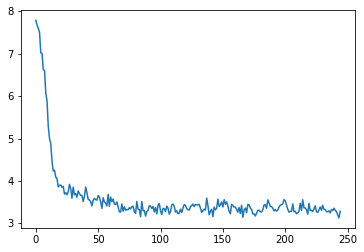

In [19]:
plt.pyplot.plot(res_mean)

In [ ]:
#continuous model try with cont action

# #env = make_vec_env('inventory_cont_model-v0', ContCONFIG = {'h': 1, 'p': 1, 'L': 10, 'lambda': 1}, n_envs=4)
# #how to set parameters???
# cont_env = make_vec_env('inventory_cont_model-v0', n_envs=8)
# cont_model = PPO(MlpPolicy, cont_env, verbose=1, gamma = 1)
# cont_model.learn(total_timesteps=200000)
# # fixed issue with vector, now action can be continuous

# #continuous evaluation
# cont_model.save("inv_cont_1")
# trained_model = PPO.load("inv_cont_1")
# env1 = gym.make('inventory_cont_model-v0')
# numiter = 50000
# res_mean, res_std = ppo_evaluate(trained_model, env1, numiter)
# print(-res_mean,'+/=',1.96*res_std/np.sqrt(5)) 

In [ ]:
#Discrete environment
#h=1,p=99,L=1,max_inventory=100,max_action=100,binomial(6,0.5)
env = make_vec_env('inventory_model-v0', n_envs=4)
model = PPO(MlpPolicy, env, verbose=1, gamma = 1)
model.learn(total_timesteps=1000000)
model.save("inv_2")

trained_model2 = PPO.load("inv_2")
env2 = gym.make('inventory_model-v0')
numiter = 200000
res_mean, res_std = ppo_evaluate(trained_model2, env2, numiter)
print(-res_mean,'+/=',1.96*res_std/np.sqrt(5)) 

In [ ]:
#Discrete environment 2
#h=1,p=99,L=1,max_inventory=100,max_action=6,binomial(6,0.5)
env = make_vec_env('inventory_model-v0', n_envs=4)
model = PPO(MlpPolicy, env, verbose=1, gamma = 1)
model.learn(total_timesteps=1000000)
model.save("inv_3")

#set action space to be small([0,1,2,3,4,5,6]) seems to get reasonable results...
trained_model3 = PPO.load("inv_3")
env3 = gym.make('inventory_model-v0')
numiter = 200000
res_mean, res_std = ppo_evaluate(trained_model3, env3, numiter)
print(-res_mean,'+/=',1.96*res_std/np.sqrt(5)) 